In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand

In [ ]:
# Importing essential libraries

import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Make predictions using ready made model (without any training)

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

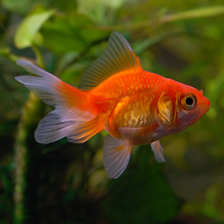

In [ ]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [ ]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [ ]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [ ]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [ ]:
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [ ]:
image_labels[predicted_label_index]

'goldfish'

In [ ]:
# Load flowers dataset

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

'./datasets/flower_photos'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/2682566502_967e7eaa2a.jpg'),
 PosixPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('datasets/flower_photos/roses/488849503_63a290a8c2_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15255964274_cf2ecdf702.jpg'),
 PosixPath('datasets/flower_photos/roses/3045046293_57f6d52065_m.jpg')]

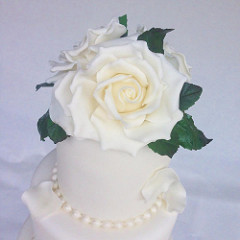

In [ ]:
Image.open(str(roses[1]))

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[PosixPath('datasets/flower_photos/tulips/13472393854_b2530f7029_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/132538273_335240fe5b_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/7166554924_432aaae4b2_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/13513644515_a51470b899.jpg'),
 PosixPath('datasets/flower_photos/tulips/15516736553_b169b67195_n.jpg')]

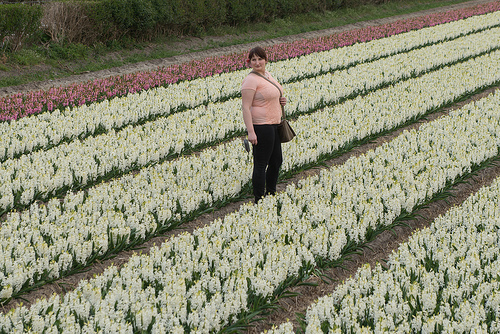

In [ ]:
Image.open(str(tulips[3]))

In [ ]:
# Dictionary

flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
# Lables

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/2682566502_967e7eaa2a.jpg'),
 PosixPath('datasets/flower_photos/roses/15319767030_e6c5602a77_m.jpg'),
 PosixPath('datasets/flower_photos/roses/488849503_63a290a8c2_m.jpg'),
 PosixPath('datasets/flower_photos/roses/15255964274_cf2ecdf702.jpg'),
 PosixPath('datasets/flower_photos/roses/3045046293_57f6d52065_m.jpg')]

In [ ]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/2682566502_967e7eaa2a.jpg'

In [ ]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [ ]:
img.shape

(313, 500, 3)

In [ ]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [ ]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# Train Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# Feature Scaling

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
# Make prediction using pre-trained model on new flowers dataset

X[0].shape

(224, 224, 3)

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [ ]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

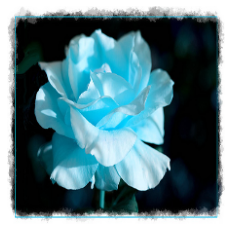

In [ ]:
plt.axis('off')
plt.imshow(X[0])

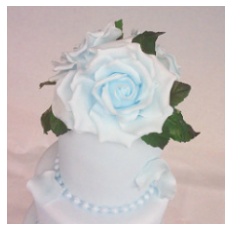

In [ ]:
plt.axis('off')
plt.imshow(X[1])

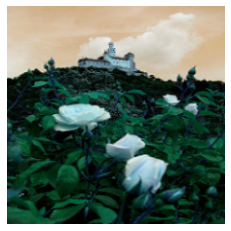

In [ ]:
plt.axis('off')
plt.imshow(X[2])

In [ ]:
# Now take pre-trained model and retrain it using flowers images

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 106s 1s/step - loss: 1.2707 - acc: 0.5057
Epoch 2/5
86/86 [==============================] - 102s 1s/step - loss: 0.4471 - acc: 0.8442
Epoch 3/5
86/86 [==============================] - 102s 1s/step - loss: 0.3143 - acc: 0.9103
Epoch 4/5
86/86 [==============================] - 102s 1s/step - loss: 0.2588 - acc: 0.9302
Epoch 5/5
86/86 [==============================] - 102s 1s/step - loss: 0.2385 - acc: 0.9391


In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 35s 1s/step - loss: 0.3918 - acc: 0.8671


[0.3917987644672394, 0.8671023845672607]